In [1]:
from lifelines import CoxPHFitter, datasets, KaplanMeierFitter
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy #import dendrogram
import seaborn
from PIL import Image
import matplotlib.colors as colors
import umap
import matplotlib.patches as mpatches
from scipy.stats import chi2_contingency
# import patsy
import matplotlib.patheffects as path_effects

In [2]:
with open('../data/final_clustering.pkl', 'rb') as f:
    cdat = pickle.load(f)
m = cdat['metabric']

In [3]:
m_cmv = ['file', 'S_10year.time', 'S_10year.status', 'grade', 'node', 'size', 'er_status', 'HER2', 'age_at_diagnosis',
         'menopausal_status_inferred', 'kl_tl', 'kl_tf', 'kl_fl', 'count_t', 'count_l', 'count_f', 'clusters', 'clusters_merged']

In [4]:
def to_quantiles(a, q):
    return np.digitize(a, np.quantile(a, q))

data = m[m_cmv].copy()[(m['er_status'] == 'pos')]
data = data[data.isna().sum(axis=1) == 0]
data['menopausal_status_inferred'] = data['menopausal_status_inferred'].apply(lambda x: 0 if x == 'pre' else 1)
data['kl_tl'] = 1 - to_quantiles(data['kl_tl'], [.25])#, .5, .75])
data['kl_tf'] = 1 - to_quantiles(data['kl_tf'], [.25])#, .5, .75])
data['kl_fl'] = 1 - to_quantiles(data['kl_fl'], [.25])#, .5, .75])
data['count_t'] = to_quantiles(data['count_t'], [.5])
data['count_l'] = to_quantiles(data['count_l'], [.5])
data['count_f'] = to_quantiles(data['count_f'], [.5])
data['age_at_diagnosis'] = data['age_at_diagnosis'] / 10.

for i in range(1, 6):
    data['clusters_' + str(i)] = data['clusters'].apply(lambda x: int(x == i))

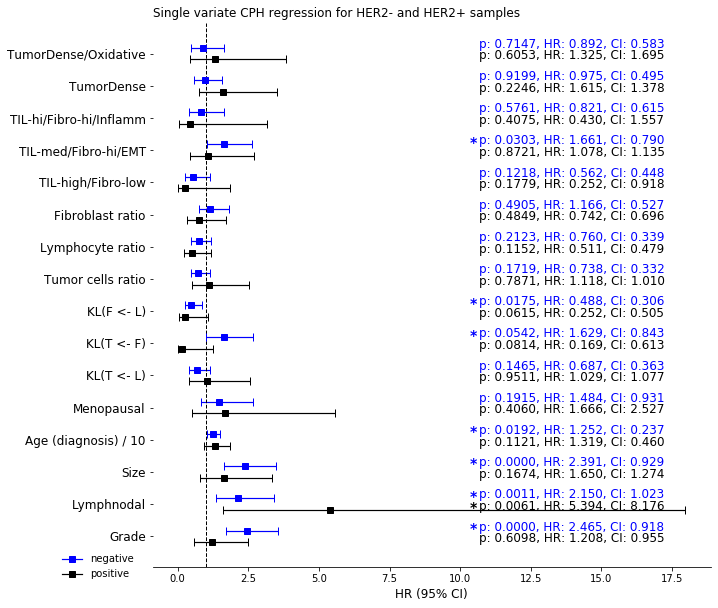

In [5]:
save_file = '../figures/fig_cox.png'
ccol = 'clusters'
cnames = cdat['cluster_names']


num_clusters = len(data[ccol].unique())
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
ax = fig.gca()
ax.axvline(1, color='black', ls='--', linewidth=1)
single_vars = ['grade', 'node', 'size', 'age_at_diagnosis', 'menopausal_status_inferred', 'kl_tl', 'kl_tf', 'kl_fl', 'count_t', 'count_l', 'count_f']
single_vars = single_vars + [ccol + '_{}'.format(i) for i in range(1, 6)] # sorted(m[ccol].unique())]
single_vars_labels = ['Grade', 'Lymphnodal', 'Size', 'Age (diagnosis) / 10', 'Menopausal'] + cdat['measure_names']
# single_vars_labels = single_vars_labels + ['cluster {} vs all'.format(i) for i in range(1, num_clusters + 1)]
single_vars_labels = single_vars_labels + cnames
pval_position = 10.65
var_margin = 0.18

for i, var in enumerate(single_vars):
    cph_s = CoxPHFitter()
    cph_s.fit(data[data['HER2'] == 'neg'], duration_col='S_10year.time', event_col='S_10year.status', formula=var)
    x = cph_s.summary['exp(coef)'][var]
    lower = x - cph_s.summary['exp(coef) lower 95%'][var]
    upper = cph_s.summary['exp(coef) upper 95%'][var] - x
    y = i + var_margin # if i in multi_vars_ind else 0)
    ax.errorbar(x, y, xerr=np.array([[lower, upper]]).T, yerr=0, fmt ='s', color='blue', ls='-', capsize=4, linewidth=1.2)
    pval = cph_s.summary['p'][var]
    ax.text(pval_position - 0.3, y - 0.07, '*' if pval < 0.06 else '', color='blue', size=14, weight='bold')
    ax.text(pval_position, y, 'p: {:.4f}, HR: {:.3f}, CI: {:.3f}'.format(pval, x, (upper + lower) / 2), color='blue', size=12)

for i, var in enumerate(single_vars):
    cph_s = CoxPHFitter()
    cph_s.fit(data[data['HER2'] == 'pos'], duration_col='S_10year.time', event_col='S_10year.status', formula=var)
    x = cph_s.summary['exp(coef)'][var]
    lower = x - cph_s.summary['exp(coef) lower 95%'][var]
    upper = cph_s.summary['exp(coef) upper 95%'][var] - x
    #y = i - (var_margin if i in multi_vars_ind else 0)
    y = i - var_margin
    ax.errorbar(x, y, xerr=np.array([[lower, upper]]).T, yerr=0, fmt ='s', color='black', ls='-', capsize=4, linewidth=1.2)
    pval = cph_s.summary['p'][var]
    ax.text(pval_position - 0.3, y - 0.07, '*' if pval < 0.06 else '', color='black', size=14, weight='bold')
    ax.text(pval_position, y, 'p: {:.4f}, HR: {:.3f}, CI: {:.3f}'.format(pval, x, (upper + lower) / 2), color='black', size=12)

ax.set_yticks(list(range(0, len(single_vars_labels))))
ax.set_yticklabels(single_vars_labels, fontdict={'fontsize': 12})
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel('HR (95% CI)', fontdict={'fontsize': 12})
ax.set_title('Single variate CPH regression for HER2- and HER2+ samples', loc='left')
ax.errorbar(None, None, fmt ='s', color='blue', ls='-', linewidth=1.2, label='negative')
ax.errorbar(None, None, fmt ='s', color='black', ls='-', linewidth=1.2, label='positive')
ax.legend(frameon=False, loc=(-.17, -.03))
plt.savefig(save_file, facecolor='w', format='png')
plt.show()

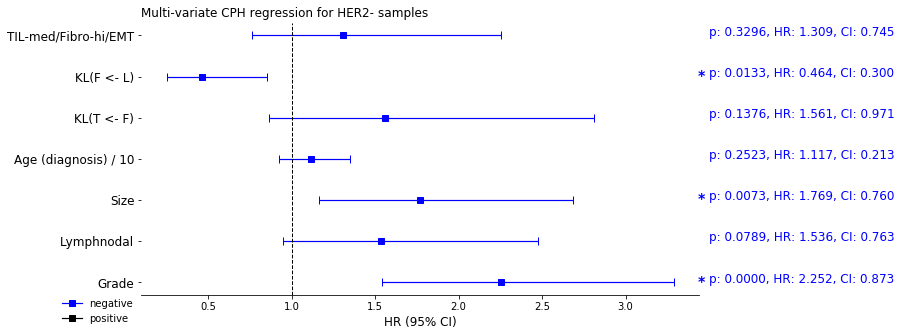

In [6]:
save_file = '../figures/fig_cox_multi.png'
ccol = 'clusters'
cnames = cdat['cluster_names']
multi_vars_ind_her2_neg = [0, 1, 2, 3, 6, 7, 12]
# multi_vars_ind_her2_pos = [0, 1, 2, 3, 6, 7, 12]

num_clusters = len(data[ccol].unique())
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax = fig.gca()
ax.axvline(1, color='black', ls='--', linewidth=1)
pval_position = 3.5

cph_m = CoxPHFitter()
cph_m.fit(data[data['HER2'] == 'neg'], duration_col='S_10year.time', event_col='S_10year.status', formula='+'.join([single_vars[i] for i in multi_vars_ind_her2_neg]))
for i, var_ind in enumerate(multi_vars_ind_her2_neg):
    var = single_vars[var_ind]
    x = cph_m.summary['exp(coef)'][var]
    lower = x - cph_m.summary['exp(coef) lower 95%'][var]
    upper = cph_m.summary['exp(coef) upper 95%'][var] - x
    y = i
    ax.errorbar(x, y, xerr=np.array([[lower, upper]]).T, yerr=0, fmt ='s', color='blue', ls='-', capsize=4, linewidth=1.2)
    pval = cph_m.summary['p'][var]
    ax.text(pval_position - 0.07, y - 0.07, '*' if pval < 0.06 else '', color='blue', size=14, weight='bold')
    ax.text(pval_position, y, 'p: {:.4f}, HR: {:.3f}, CI: {:.3f}'.format(pval, x, (upper + lower) / 2), color='blue', size=12)
    
ax.set_yticks(list(range(0, len(multi_vars_ind_her2_neg))))
ax.set_yticklabels([single_vars_labels[i] for i in multi_vars_ind_her2_neg], fontdict={'fontsize': 12})
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel('HR (95% CI)', fontdict={'fontsize': 12})
ax.set_title('Multi-variate CPH regression for HER2- samples', loc='left')
ax.errorbar(None, None, fmt ='s', color='blue', ls='-', linewidth=1.2, label='negative')
ax.errorbar(None, None, fmt ='s', color='black', ls='-', linewidth=1.2, label='positive')
ax.legend(frameon=False, loc=(-.15, -.12))
plt.savefig(save_file, facecolor='w', format='png')
plt.show()

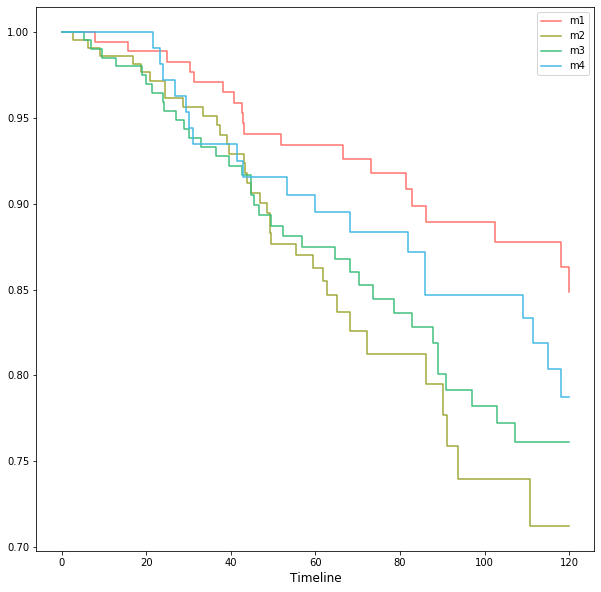

In [7]:
# ccol = 'clusters'
# save_file = 'fig_km.svg'
# cnames = cdat['cluster_names']

ccol = 'clusters_merged'
save_file = '../figures/fig_km_merged.png'
cnames = cdat['merged_cluster_names']


kmf = {}
vals = data[ccol].unique()
vals.sort()
for v in vals:
    select = data[ccol] == v
    kmf[v] = KaplanMeierFitter().fit(durations=data['S_10year.time'][select], event_observed=data['S_10year.status'][select], label=str(v))

fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
ax = plt.gca()
for v in vals:
    kmf[v].plot_survival_function(ax=ax, color=cdat['cluster_colors'][v-1], label=cnames[v-1], ci_show=False)
ax.set_xlabel('Timeline', fontdict={'fontsize': 12})
ax.legend()
plt.savefig(save_file, facecolor='w', format='png')
plt.show()